# This code should plot out the most figures I need in section 3.2

In [1]:
import numpy as np
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
import sympy
%matplotlib inline
plt.style.use('bmh')
import scipy
from scipy import stats
from scipy import sparse
from scipy.sparse import linalg
from scipy.sparse.linalg import spsolve
from scipy.stats import norm

In [2]:
import sympy
z = sympy.symbols('z')
K0 = 1e-6# m * * 2 / s
K1 = 6e-3# m / s
Aalpha = 0.5
c=20
w=0

sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)

Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz=  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta,np)


In [3]:
#######
#Euler#
#######
def step_e(z,H,dt,N_sample):

    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    a=dKdz(z)
    b=np.sqrt(2*Diffu(z))
    temp=z+a*dt+b*dW
    return temp

def step_e_const(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    K0=3e-3
    b=np.sqrt(2*K0)
    
    temp=z+b*dW
    return temp

########
#Visser#
########
def step_v(z,H,dt,N_sample):
    
    #Original
    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3
    
    #Wiener process
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    r=dt
    
    a=dKdz(z)
    G=Diffu(z+a*dt/2)
    
    temp= z + a*dt + np.sqrt(2/r*dt*G)*dW
    return temp

def step_v_const(z,H,dt,N_sample):
    K0=3e-3
    
    #Original
    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3
    
    #Wiener process
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    r=dt
    
    temp= z + np.sqrt(2/r*dt*K0)*dW
    return temp

##############
#Milstein 1nd#
##############
def step_m(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    temp= z + (1/2)*dKdz(z)*(dW*dW+dt) + Beta(z)*dW
    return temp

##############
#Milstein 2nd#
##############
def step_m2(z,H,dt,N_sample):
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    k=Diffu(z)
    dkdz=dKdz(z)
    ddkdz=dAdz(z)
    dddkdz=ddAdzz(z)
    sqrt2k=np.sqrt(2*k)
    
    a=dkdz
    da=ddkdz
    dda=dddkdz
    b= sqrt2k 
    db=dkdz/b
    ddb=ddkdz/b - ((dkdz)**2)/b**3
    ab=da*b+a*db
    
    temp= z + a*dt+b*dW+1/2*b*db*(dW*dW-dt)+1/2*(ab+1/2*ddb*b**2)*dW*dt+\
            1/2*(a*da+1/2*dda*b**2)*dt**2
    
    return temp

def step_m2_const(z,H,dt,N_sample):
    K0=3e-3
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    temp= z +np.sqrt(2*K0)*dW
    return temp

In [4]:
def oneStep(Z ,scheme, H, dt):
    
    Z_Origin = Z.copy()
    Z = scheme(Z, H, dt, Z.size)
    
    maskCross = ((H < Z) | (0 > Z))
    Crossing = Z_Origin[maskCross]
    
    Z = np.where(Z < 0, -Z, Z)
    Z = np.where(Z > H, 2*H - Z, Z)
    
    Landing = Z[maskCross]
    
    return Z, Crossing, Landing

In [5]:
def parallel(Tmax, dt, H, Testdepth, Np, Nbins, quene, queneCross, queneLand, scheme):
    
    np.random.seed()
    Ntime   =int(Tmax/dt)

    hist_ = np.zeros((Nbins-1,),'i')
    hist_Cross = np.zeros((Nbins-1,),'i')
    hist_Land = np.zeros((Nbins-1,),'i')

    z = np.random.uniform(0 , H,int(Np))

    for i in range(Ntime):

        z, Cross, Land = oneStep( z,    scheme,         H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(z, bins = np.linspace(0, Testdepth, Nbins))
        hist_ = hist_ + temp0
        
        temp2, _ = np.histogram(Cross, bins = np.linspace(0, Testdepth, Nbins))
        hist_Cross = hist_Cross + temp2
        
        temp3, _ = np.histogram(Land, bins = np.linspace(0, Testdepth, Nbins))
        hist_Land = hist_Land + temp3 

        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
            
    quene.put(hist_)
    queneCross.put(hist_Cross)
    queneLand.put(hist_Land)
    
    return None
        
def RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

    Ntime     = int(Tmax/dt)  #Number of time interval
    counter = Ntime

    if (__name__ == '__main__'):
        
        threads=[]
        quene = mp.Queue()
        queneCross = mp.Queue()
        queneLand = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target= parallel, 
                                args= (Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                       quene, queneCross,
                                       queneLand, scheme))
            
            threads.append(thread)
            thread.start()    #starting calculation.

        for thread in threads:  
            thread.join()     #waiting these processes finish. 

    hist_  = np.zeros((Nbins-1,),'i')
    hist_Cross  = np.zeros((Nbins-1,),'i')
    hist_Land   = np.zeros((Nbins-1,),'i')

    for i in range(NumberOfThread):
        hist_      += quene.get()
        hist_Cross += queneCross.get()
        hist_Land += queneLand.get()

    hist_  = hist_  / counter
    hist_  = hist_  / np.mean(hist_)
    
    lists=[]
    lists.append(hist_)
    
    lists_2 = []
    lists_2.append(hist_Cross)
    
    lists_3 =[]
    lists_3.append(hist_Land)
    
    return hist_, hist_Cross, hist_Land

# Here we simulate $\Delta t$ = 10

In [6]:
Np        = 240000
Nbins     = 200
dt        = 10
Tmax = dt*1*3600
H         = 10
Testdepth = 0.2
NumberOfThread = 4

startTime = time()
E1, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e)

E1_C, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e_const)

V1, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_v)

V1_C, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_v_const)

M1, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_m)

M2, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_m2)

endTime = time()
print("Time elapsed: ", endTime-startTime)

Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Time elapsed:  341.7451901435852


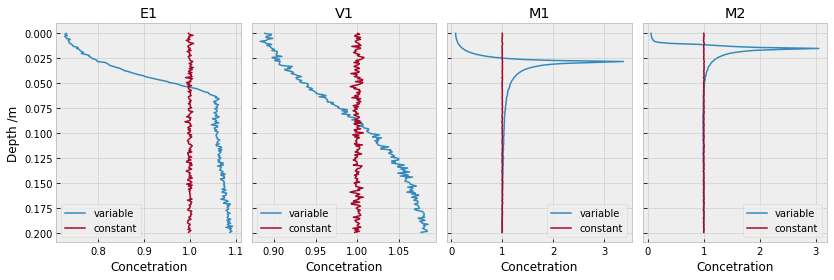

In [7]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.69,4), sharey = True)
#fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27))
ax[0].plot(E1, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(E1_C, midpoints, linewidth=1.5, label= "constant")
ax[0].set_xlabel('Concetration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('E1')
ax[0].invert_yaxis()
ax[0].legend()

ax[1].plot(V1, midpoints, linewidth=1.5, label= "variable")
ax[1].plot(V1_C, midpoints, linewidth=1.5, label= "constant")
ax[1].set_xlabel('Concetration')
ax[1].set_title('V1')
ax[1].legend()

ax[2].plot(M1, midpoints, linewidth=1.5, label= "variable")
ax[2].plot(E1_C, midpoints, linewidth=1.5, label= "constant")
ax[2].set_xlabel('Concetration')
ax[2].set_title('M1')
ax[2].legend()

ax[3].plot(M2, midpoints, linewidth=1.5, label= "variable")
ax[3].plot(E1_C, midpoints, linewidth=1.5, label= "constant")
ax[3].set_xlabel('Concetration')
ax[3].set_title('M2')
#ax[3].set_xlim(0.7, 1.3)
ax[3].legend()

plt.tight_layout()

# Here we simulate $\Delta t$ = 0.1

In [8]:
Np        = 240000
Nbins     = 200
dt        = 0.1
Tmax =dt*10*3600
H         = 10
Testdepth = 0.2
NumberOfThread = 4

startTime = time()
E1, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e)

E1_C, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e_const)

V1, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_v)

V1_C, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_v_const)

M1, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_m)

M2, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_m2)

endTime = time()
print("Time elapsed: ", endTime-startTime)

Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Time elapsed:  3312.869124650955


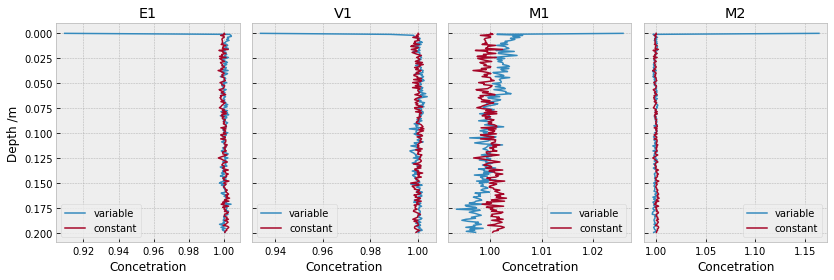

In [9]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.69,4), sharey = True)
#fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27))
ax[0].plot(E1, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(E1_C, midpoints, linewidth=1.5, label= "constant")
ax[0].set_xlabel('Concetration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('E1')
ax[0].invert_yaxis()
ax[0].legend()

ax[1].plot(V1, midpoints, linewidth=1.5, label= "variable")
ax[1].plot(V1_C, midpoints, linewidth=1.5, label= "constant")
ax[1].set_xlabel('Concetration')
ax[1].set_title('V1')
ax[1].legend()

ax[2].plot(M1, midpoints, linewidth=1.5, label= "variable")
ax[2].plot(E1_C, midpoints, linewidth=1.5, label= "constant")
ax[2].set_xlabel('Concetration')
ax[2].set_title('M1')
ax[2].legend()

ax[3].plot(M2, midpoints, linewidth=1.5, label= "variable")
ax[3].plot(E1_C, midpoints, linewidth=1.5, label= "constant")
ax[3].set_xlabel('Concetration')
ax[3].set_title('M2')
#ax[3].set_xlim(0.7, 1.3)
ax[3].legend()

plt.tight_layout()

# Here we plot the whole water column, Testdepth = H

In [13]:
Np        = 240000
Nbins     = 200
dt        = 10
Tmax = dt*1*3600
H         = 10
Testdepth = H
NumberOfThread = 4

startTime = time()
E1, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e)

E1_C, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e_const)

V1, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_v)

V1_C, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_v_const)

M1, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_m)

M2, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_m2)

endTime = time()
print("Time elapsed: ", endTime-startTime)

Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Time elapsed:  348.8896653652191


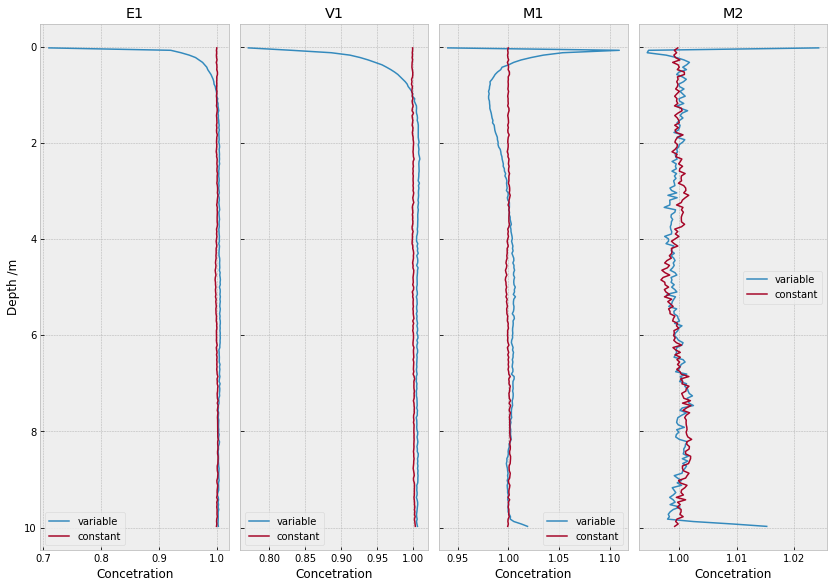

In [14]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27), sharey = True)
#fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27))
ax[0].plot(E1, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(E1_C, midpoints, linewidth=1.5, label= "constant")
ax[0].set_xlabel('Concetration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('E1')
ax[0].invert_yaxis()
ax[0].legend()

ax[1].plot(V1, midpoints, linewidth=1.5, label= "variable")
ax[1].plot(V1_C, midpoints, linewidth=1.5, label= "constant")
ax[1].set_xlabel('Concetration')
ax[1].set_title('V1')
ax[1].legend()

ax[2].plot(M1, midpoints, linewidth=1.5, label= "variable")
ax[2].plot(E1_C, midpoints, linewidth=1.5, label= "constant")
ax[2].set_xlabel('Concetration')
ax[2].set_title('M1')
ax[2].legend()

ax[3].plot(M2, midpoints, linewidth=1.5, label= "variable")
ax[3].plot(E1_C, midpoints, linewidth=1.5, label= "constant")
ax[3].set_xlabel('Concetration')
ax[3].set_title('M2')
#ax[3].set_xlim(0.7, 1.3)
ax[3].legend()

plt.tight_layout()

# Plot diffusivty profile

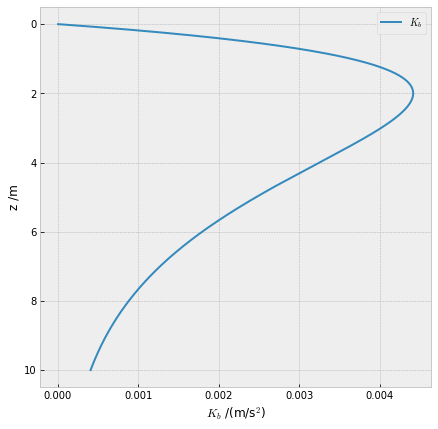

In [69]:
z = np.linspace(0, 10, 1000)
plt.figure(figsize=(7,7))
plt.plot(Diffu(z), z, label = "$K_b$")
plt.gca().invert_yaxis()
plt.ylabel("z /m")
plt.xlabel("$K_b$ /(m/s$^2$)")
plt.legend()
plt.show()